In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
print(sales_train.shape)
sales_train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [9]:
# train = pd.merge(left=sales_train, right=items, on='item_id')
# train = pd.merge(left=train, right=shops, on='shop_id')
# train = pd.merge(left=train, right=item_categories, on='item_category_id')
train = (sales_train.join(items, on='item_id', rsuffix='_')
         .join(shops, on='shop_id', rsuffix='_')
         .join(item_categories, on='item_category_id', rsuffix='_'))
train.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1, inplace=True)

In [10]:
print(train.shape)
train.head()

(2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [11]:
print('Min date from train set:', train['date'].min())
print('Max date from train set:', train['date'].max())

Min date from train set: 01.01.2013
Max date from train set: 31.12.2014


# Check nulls

In [12]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
dtype: int64

# Data Leakages

We are gonna use 'shop id' and 'item id' to get the data leakages

In [13]:
test_shop_id = test['shop_id'].unique()
test_item_id = test['item_id'].unique()
# get the rows if the shop ids in train and test are the same
clean_train = train[train['shop_id'].isin(test_shop_id)]
# get the rows if the item ids in train and test are the same
clean_train = clean_train[clean_train['item_id'].isin(test_item_id)]
train.shape, clean_train.shape

((2935849, 10), (1224439, 10))

# Data Cleaning

In [14]:
train = train[train['item_price'] > 0]
train.shape

(2935848, 10)

# Data Proccessing

- I'm dropping the text features cuz I'm not gonna do anything with them.
- We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [15]:
# Select only useful features.
train_monthly = clean_train[['date', 'date_block_num',
                          'shop_id', 'item_category_id', 
                          'item_id', 'item_price', 'item_cnt_day']]
print(train_monthly.shape)

(1224439, 7)


In [16]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = (train_monthly.sort_values('date')
                 .groupby(['date_block_num', 'shop_id', 'item_category_id', 
                           'item_id'], as_index=False))

In [17]:
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 
                         'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
print(train_monthly.shape)
train_monthly.head()

(600159, 9)


,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.857143,9.0,1.285714,7
1,0,2,2,5643,4775.21,2387.605000,0.0,0.000000,2
2,0,2,5,5583,1188.30,594.150000,2.0,1.000000,2
3,0,2,6,7893,5970.00,1990.000000,3.0,1.000000,3
4,0,2,6,7894,1490.00,1490.000000,1.0,1.000000,1


To mimic the real behavior of the data we have to create the missing records from the loaded dataset, so for each month we need to create the missing records for each shop and item, since we don't have data for them I'll replace them with 0

In [18]:
# Build a data set with all the possible combinations
# of ['date_block_num','shop_id','item_id'] 
# so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34): # 34 -> max date block num (0:33)
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
print(empty_df.shape)
empty_df.head()

(6734448, 3)


,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894


In [19]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)
print(train_monthly.shape)
train_monthly.head()

(6734448, 9)


,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0


In [20]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0,2013,0


# EDA

In [21]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

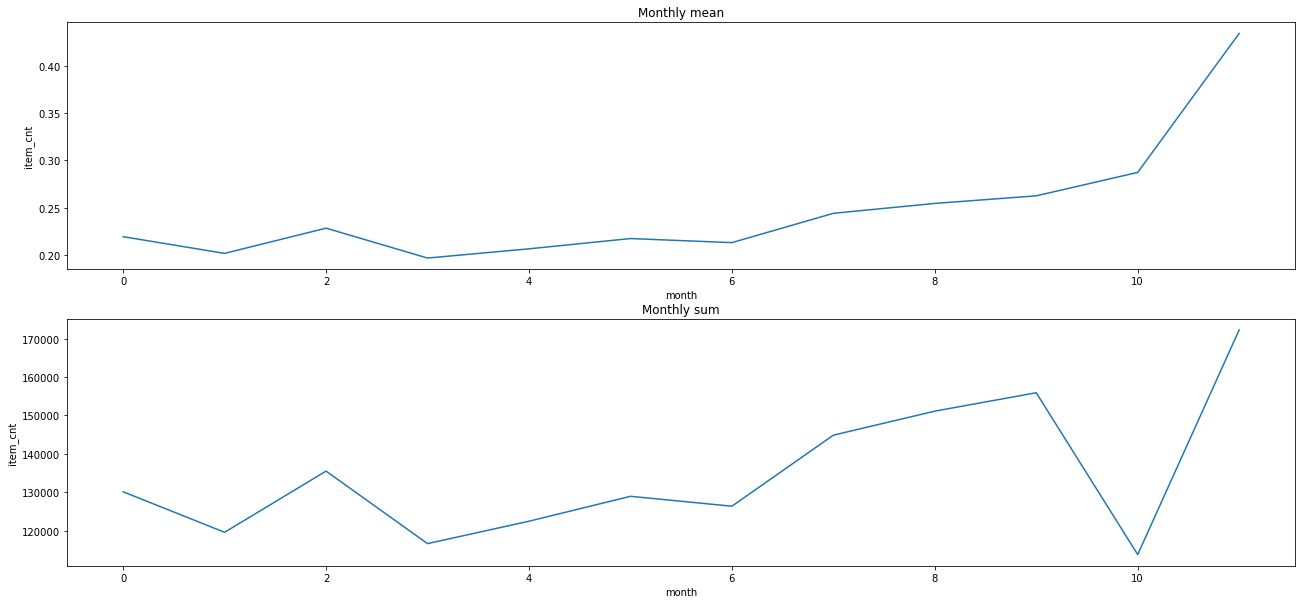

In [22]:
f, axes = plt.subplots(2, 1, figsize=(22, 10))
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

As we can see we have a trending increase of item sales count (mean) towards the ending of the year.

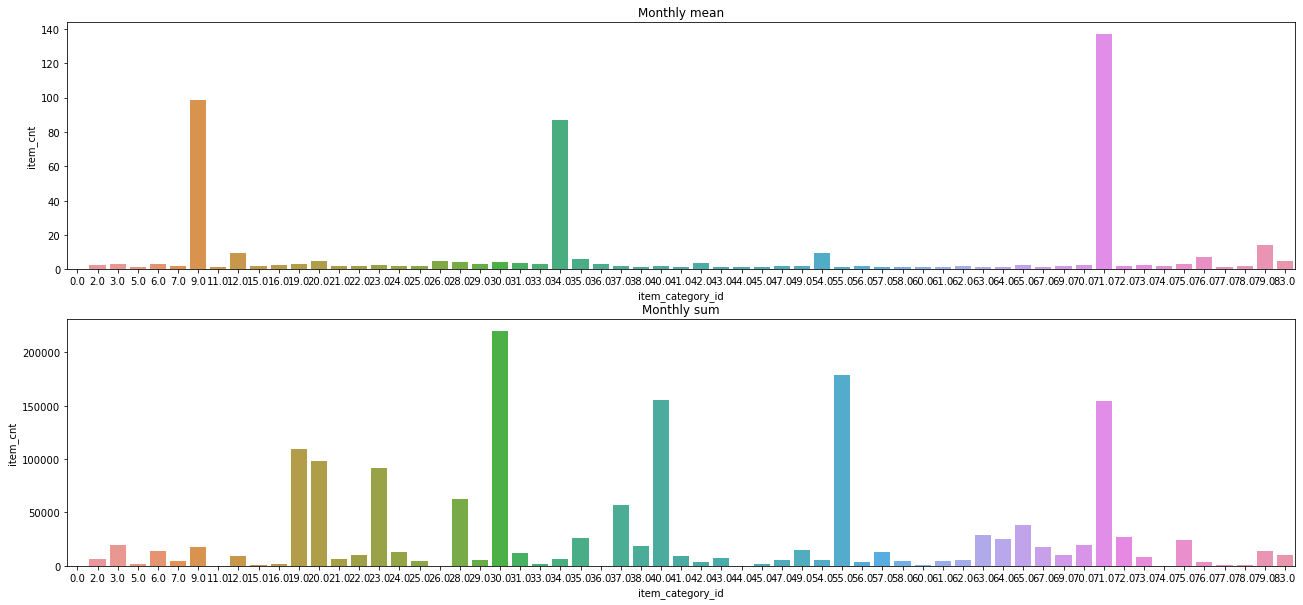

In [23]:
f, axes = plt.subplots(2, 1, figsize=(22, 10))
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0]).set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

Also only few of the categories seems to hold most of the sell count.

### What shop sells more?

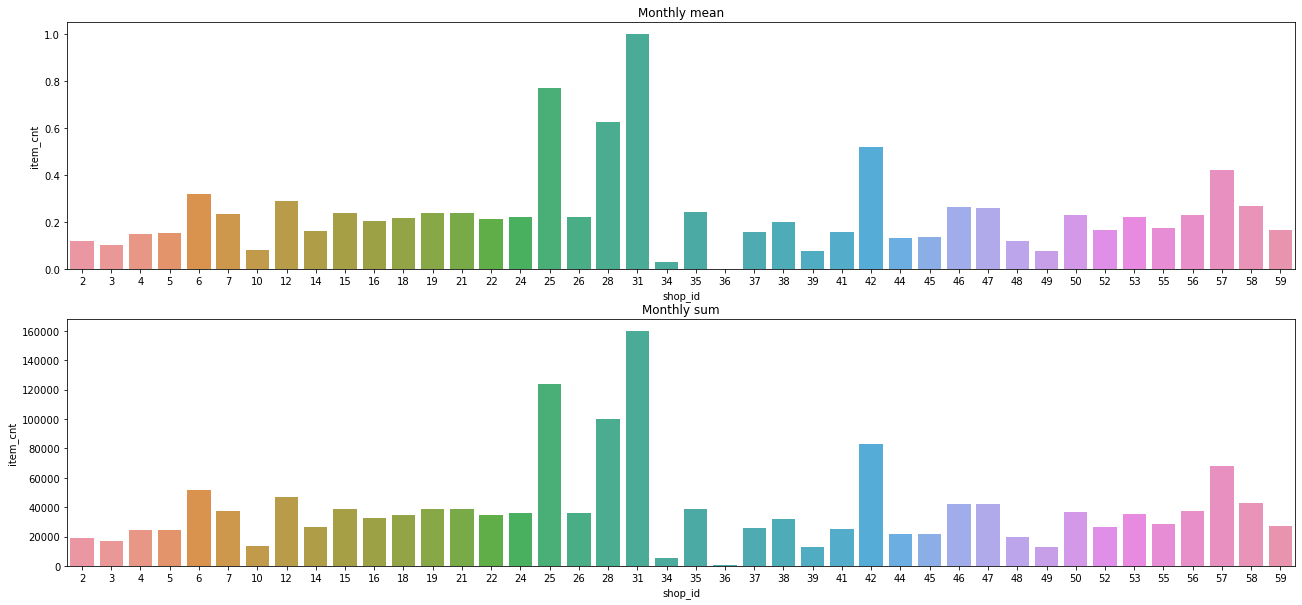

In [24]:
f, axes = plt.subplots(2, 1, figsize=(22, 10))
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0]).set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

Most of the shops have a similar sell rate, but 3 of them have a much higher rate, this may be a indicative of the shop size.

# Outliers

<AxesSubplot:xlabel='item_cnt'>

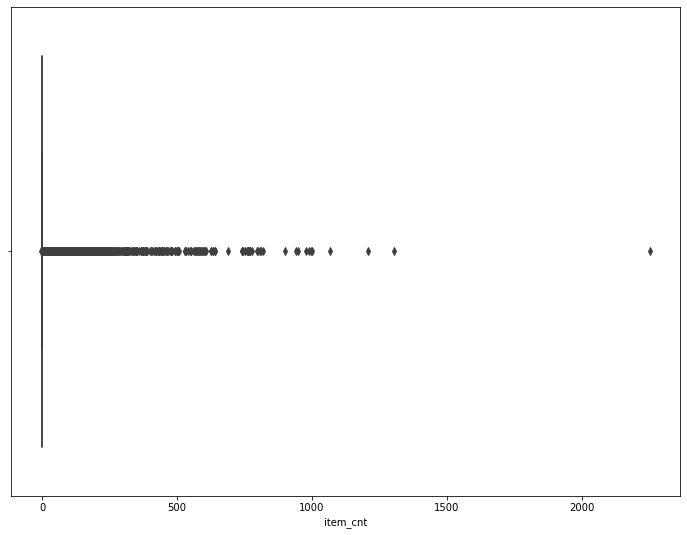

In [25]:
plt.figure(figsize=(12, 9))
sns.boxplot(train_monthly['item_cnt'])

In [26]:
print(train_monthly.shape)
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')
print(train_monthly.shape)

(6734448, 11)
(6728118, 11)


### Creating the label
Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

In [27]:
train_monthly['item_cnt_month'] = (train_monthly.sort_values('date_block_num')
                                   .groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1))
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0,2013,0,1.0
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0,2013,0,0.0
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0,2013,0,1.0
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0,2013,0,2.0
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0,2013,0,2.0


# Feature engineering

## Unitary item prices.

In [28]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

## Group based features.

In [29]:
gp_item_price = (train_monthly.sort_values('date_block_num')
                 .groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]}))

gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

How much each item's price changed from its (lowest/highest) historical price

In [30]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

## Rolling window based features (window = 3 months).

In [31]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

## Lag based features.

In [32]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = (train_monthly.sort_values('date_block_num')
                              .groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag))
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

## Item sales count trend.

In [33]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [34]:
print(train_monthly.shape)
train_monthly.head()

(6728118, 25)


,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0,2013,0,1.0,1192.0,0.0,18979.5,10730.00,8249.50,9.0,9.0,9.0,0.0,0.0,0.0,0.0,2.25
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0,2013,0,0.0,inf,0.0,35260.0,4775.21,30484.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0,2013,0,1.0,594.0,0.0,5592.0,1188.30,4403.70,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.50
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0,2013,0,2.0,1990.0,0.0,27950.0,5970.00,21980.00,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.75
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0,2013,0,2.0,1490.0,0.0,25880.0,1490.00,24390.00,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.25


In [35]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,1.649878e+01,9.811429,0.0,8.0,16.0,25.0,3.300000e+01
shop_id,6728118.0,3.164343e+01,17.563488,2.0,16.0,35.0,47.0,5.900000e+01
item_id,6728118.0,1.104287e+04,6209.703870,30.0,5386.0,11266.0,16068.0,2.216700e+04
item_category_id,6728118.0,3.752608e+00,13.156585,0.0,0.0,0.0,0.0,8.300000e+01
item_price,6728118.0,1.698011e+02,1797.753805,0.0,0.0,0.0,0.0,3.668600e+05
mean_item_price,6728118.0,7.981663e+01,525.620638,0.0,0.0,0.0,0.0,4.299000e+04
item_cnt,6728118.0,1.851533e-01,0.907449,0.0,0.0,0.0,0.0,2.000000e+01
mean_item_cnt,6728118.0,9.324923e-02,0.312189,0.0,0.0,0.0,0.0,2.000000e+01
transactions,6728118.0,1.676328e-01,0.743099,0.0,0.0,0.0,0.0,1.900000e+01
year,6728118.0,2.013941e+03,0.802274,2013.0,2013.0,2014.0,2015.0,2.015000e+03
